
Press 1 to search a city 
Press 2 to search a defined location 
 :  1

Enter city in format: city, state, country
 :  San Marcos, California, USA


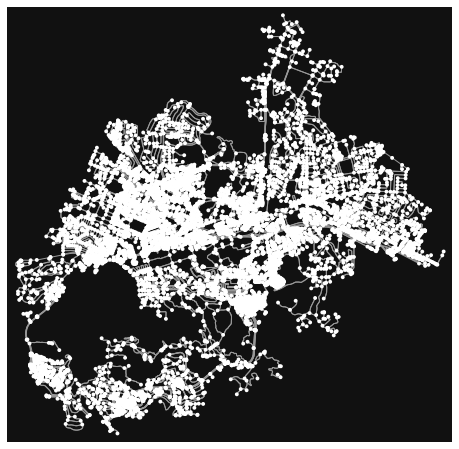


There are 9914 coordinates found from OSMnx 



Press 1 to request images 
Press 2 to search a new location 
Press 3 to quit 
 :  3



Quitting...


In [1]:
import os
import re
import urllib.request
import json
import requests
import random

#needed for osmnx
import osmnx as ox
import networkx as nx
import numpy as np
from shapely.geometry import mapping
from IPython.display import Image
from collections import defaultdict
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

"""
This script runs in jupyter notebook
It is a combination of script prototype_2.py and prototype_OSMnx.py
In order to run see directions in the user manual to install miniconda and jupyterlab
This script asks the user for input values and uses OPSMnx to generate the network graph
and nodes then it requests images from Google Street View API
"""


#----------------------------------------------------------------
# needed parameters to request images from Google Street View API
directory = "" # set to own local directory
API_key = "&key=" + "" # set to own API key
size = "640x640" # 640x640 is max 


#----------------------------------------------------------------
# called first to obtain metadata and check status
def GetMeta(address, directory):
  base = "https://maps.googleapis.com/maps/api/streetview/metadata?"
  location = "&location=" + address
  url = base + location + API_key
  file = address + ".json" # formats .json file to be saved 
  meta = requests.get(url) # requests metadata from GSV API
  meta_info = meta.json()  
  meta_status = meta_info['status'] 
  if meta_status == 'OK' : 
    print("Request found")
    print(meta_info)
    
    with open(os.path.join(directory, file), 'w') as f: # saves metadata into file in directory
      json.dump(meta_info, f)  

    GetStreet(address, directory) # requests images 

  else :
    print("Request cannot be made") # if status != OK, no image is requested 
    print(meta_info)
    
 
#----------------------------------------------------------------
# ran only if status == OK
def GetStreet(address, directory):
  base = "https://maps.googleapis.com/maps/api/streetview?size=" + size
  location = "&location=" + address 
  heading = "&heading=0" # north direction
  file = address + "_A1.jpg"
  url = base + location + heading + API_key
  urllib.request.urlretrieve(url, os.path.join(directory, file))

  heading = "&heading=90" # east direction
  file = address + "_A2.jpg"
  url = base + location + heading + API_key
  urllib.request.urlretrieve(url, os.path.join(directory, file))

  heading = "&heading=180"
  file = address + "_A3.jpg" # south direction
  url = base + location + heading + API_key
  urllib.request.urlretrieve(url, os.path.join(directory, file))

  heading = "&heading=270" # west direction
  file = address + "_A4.jpg" 
  url = base + location + heading + API_key
  urllib.request.urlretrieve(url, os.path.join(directory, file))

    
#----------------------------------------------------------------
# for obtaining coordinate points from OSMnx
# queries the user for inputs 
def OSMnx():
    userinput = int(input("\nPress 1 to search a city \nPress 2 to search a defined location \n : "))

    if userinput == 1 :
        usercity = input("\nEnter city in format: city, state, country\n : ")
        try : 
            G = ox.graph_from_place(usercity, network_type = 'all')      # error handling for invalid inputs          
        except : 
            print("\nError! Check for valid inputs \nRestarting...")     # restarts if invalid
            OSMnx() 
        else :
            G = ox.graph_from_place(usercity, network_type = 'all')
        
    elif userinput == 2 :
        userloc = int(input("\nPress 1 to enter address \nPress 2 to enter a coordinate \n : "))
    
        if userloc == 1 :
            addr = input("\nEnter address \n :")
            dist = int(input("Enter meters to search within (1 mile = 1600 meters) \n : "))
            try : 
                G = ox.graph_from_address(addr, dist, network_type = 'all')                
            except : 
                print("\nError! Check for valid inputs \nRestarting...")
                OSMnx()
            else :
                G = ox.graph_from_address(addr, dist, network_type = 'all')
                
        elif userloc == 2:
            lat = float(input("\nEnter latitude coordinate \n :"))
            long = float(input("Enter longitude coordinate \n :"))
            dist = int(input("Enter meters to search within (1 mile = 1600 meters) \n :"))
            try : 
                G = ox.graph_from_point((lat, long), dist, network_type = 'all')                
            except : 
                print("\nError! Check for valid inputs \nRestarting...")
                OSMnx()
            else :
                G = ox.graph_from_point((lat, long), dist, network_type = 'all')
    
    else :
        print("\nInvalid Choice. Restarting...")
        OSMnx()
    
    ox.plot_graph(G) # creates the graph
    nodes,edges = ox.graph_to_gdfs(G)
    list = G.nodes 
    coord = []

    # adds lat and long to new list
    for i in list:
        lat = str(G.nodes[i]['y'])
        long = str(G.nodes[i]['x'])
        point = lat + ',' + long 
        coord.append(point)

    print("\nThere are " + str((len(coord))) + " coordinates found from OSMnx \n")
    user = int(input("Press 1 to request images \nPress 2 to search a new location \nPress 3 to quit \n : "))

    if user == 1 :
        samplesize = int(input("\nPlease enter a value for a sample size lower than total coordinates \n : "))
        
        # runs while loop to check sample size
        while samplesize > len(coord) : 
            samplesize = (int(input("\nError! Invalid value. Value cannot exceed total coordinates found. Please enter a value lower than the total \n :")))
       
        # creates a new list to add a random item from original list to new list
        x = 0
        randomsample = []
        while x < samplesize :
            r = random.choice(coord)
            randomsample.append(r)
            coord.remove(r)
            x+=1
        
        for i in randomsample:
            GetMeta(i, directory)
            
        choice = int(input("\nPress 1 to search another location \nPress 2 to quit \n: "))
        if choice == 1 :
            OSMnx()
        else :
            print("\nQuitting...")
            quit()
            
    elif user == 2:
        OSMnx()
    else : 
        print("\nQuitting...")
        quit()

        
#----------------------------------------------------------------  
# Beginning of the search 

OSMnx()